In [ ]:
# I noticed on some of Ian's images that the lattice wasn't being completely masked.
# I suspect the reason is the search is missing those points because we aren't extending the grid to cover
# The whole image.

# OR

# The problem could be that I am not completely masking a point.

In [ ]:
# I need a way to look at the power spectrum of an image after subtraction. Let's pick an example and take
# it to that point.

# Copy/paste some parameters from mask_pbsapo_micrographs.ipynb

# And closely examine what is happening in each step of the way

In [8]:
import saxtal_functions as sax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import os
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdsec_opened
from itertools import product

plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
import time
import multiprocessing
import os

In [25]:
threshold_method='sd' 
pixel_size = 1.048
verbose=True
show_plots=True
threads=16
sigma=9
num_sd=3.5
num_sd_secondpass=2.5
x_window_percent=(0.002, 0.95)
y_window_percent=(0, 1)
miller_index_buffer=10
box_radius=5
min_lattice_size=3
epsilon=0.0707
mask_hotpixels=False
mask_radius=3
replace_angle=30
return_spots=False
return_stats=False
return_image=False

filename = 'test_data/test_lattice.mrc'
filename_out = 'test_data/test_lattice_masked.mrc'

scipy_fft(): FFT performed in 98.93 milliseconds.
Number of first-pass spots found: 895


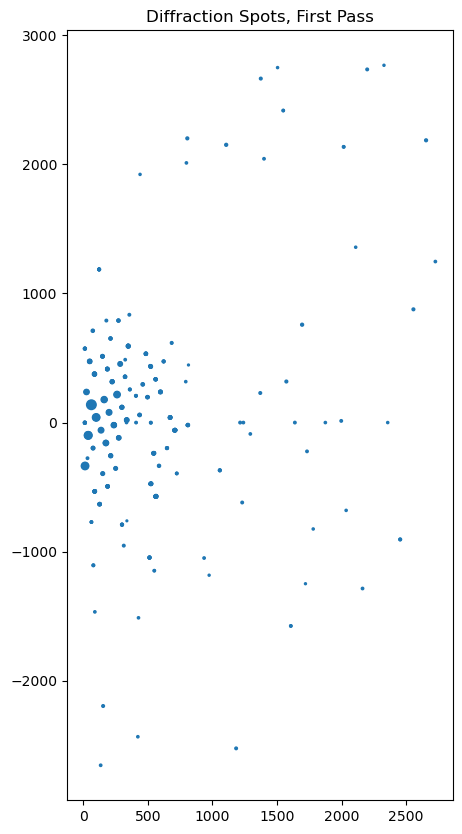

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


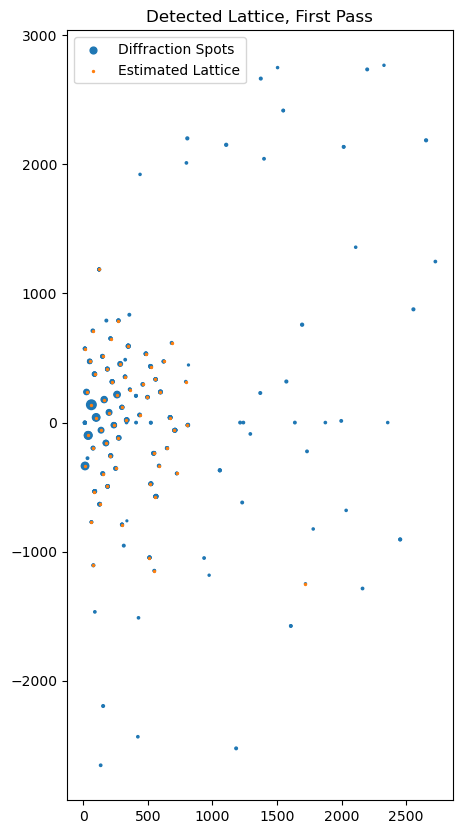

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.36229594 -98.83331765]
 [ 99.16015353  37.22370443]]
Unit cell dimensions (A): 56.58 57.16
Highest resolution spot (A): 2.84


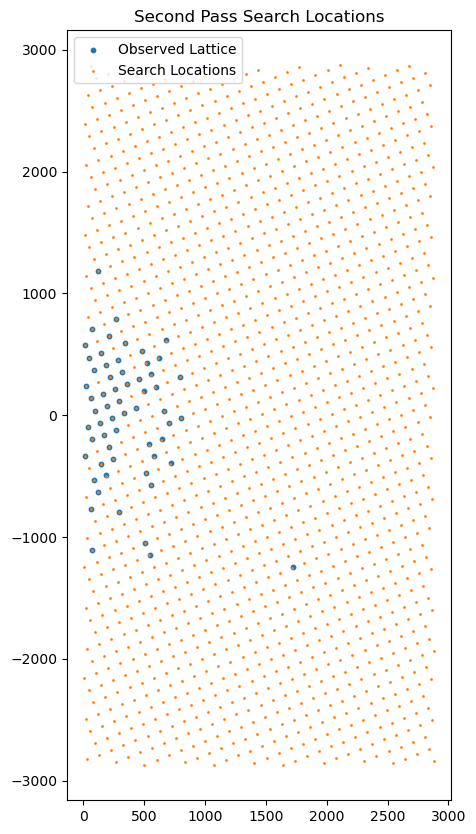

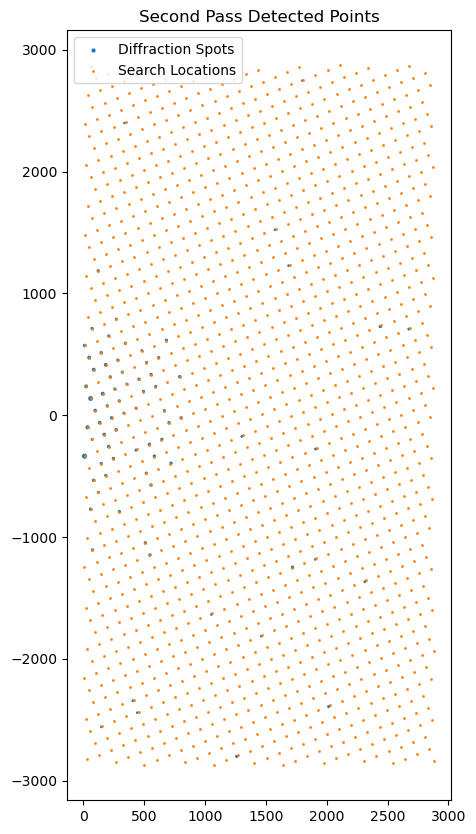

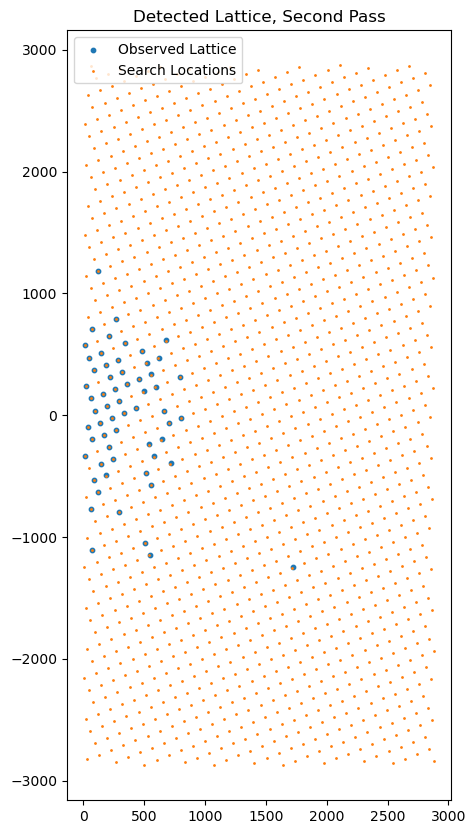

Highest resolution spot from second pass (A): 2.84


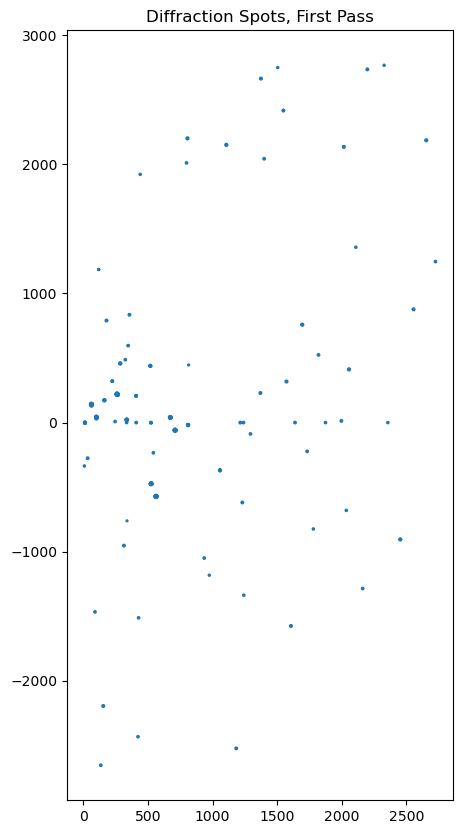

Starting basis: [[220 141]
 [260  61]]
Starting basis size: 139602
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 26.369168933364676
[220 260] is larger than [141  61]
The updated basis vectors are [ 79 199][141  61]
This run resulted in a basis smaller than the last: 69444
The updated basis vectors are: [[ 79 141]
 [199  61]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 44.95319577072957
[ 79 199] is larger than [141  61]
The updated basis vectors are [-62 138][141  61]
This run resulted in a basis smaller than the last: 46490
The updated basis vectors are: [[-62 141]
 [138  61]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 90.79873622992724
[141  61] is larger than [-62 138]
The updated basis vectors are [ 79 199][-62 138]
This run resulted in a basis larger than the last: 68730
Terminating loop.
------------

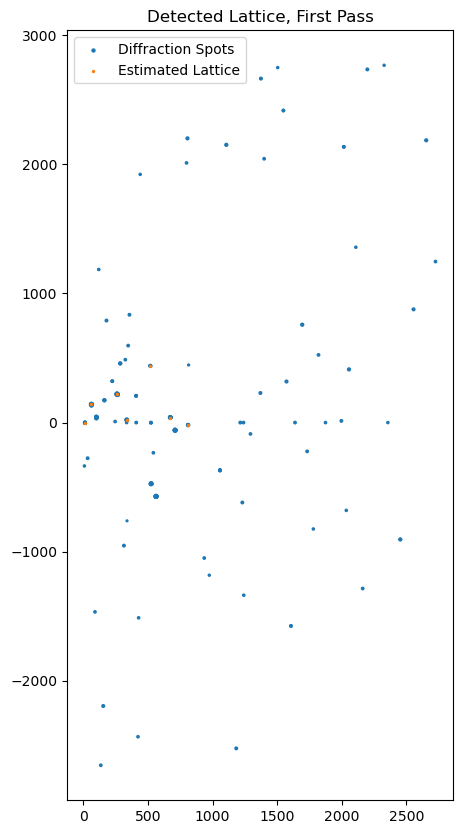

Starting basis: [[-62 141]
 [138  61]]
Refined_basis: [[-60.2        140.13333333]
 [137.7         60.76666667]]
Unit cell dimensions (A): 40.17 39.52
Lattice unit cell min dimension is 39.52 Angstrom. Terminating function.


In [26]:
masked_fft = sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_angle = replace_angle,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = True,
               return_image = False)

In [ ]:
# Import the image
image, header = sax.import_mrc(filename)

# Perform an FFT of the image
padded_fft = sax.scipy_fft(image, verbose, threads)

# Subtract the FFT from a Gaussian-smoothed FFT
log_diff_spectrum, smoothed_spectrum, amplitude_spectrum = sax.generate_diff_spectrum(padded_fft, sigma)

# Find diffraction spots
if threshold_method == "quantile":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_quantile(log_diff_spectrum, quantile, x_window_percent, y_window_percent)
if threshold_method == "sd":
    diffraction_indices, diffraction_amplitudes = sax.find_diffraction_spots_sd(log_diff_spectrum, amplitude_spectrum, num_sd, x_window_percent, y_window_percent)

# Return some info if function is verbose
if verbose:
    print("Number of first-pass spots found: " + str(diffraction_indices.shape[1]))

In [ ]:
# Plot the points found on the first pass (thresholding with num_sd)

log_diff_spectrum_s = sfft.fftshift(log_diff_spectrum, axes=0)
unwrapped_indices = sax.unwrap_indices(diffraction_indices, log_diff_spectrum)
unwrapped_indices[0,:] = unwrapped_indices[0,:] + np.shape(log_diff_spectrum)[0]/2

plt.matshow(log_diff_spectrum_s,
           cmap = "Greys_r",
           vmax = 3,
           vmin = 0)

plt.scatter(x = unwrapped_indices[1,:], y = unwrapped_indices[0,:], s = 1, alpha = 0.1)
plt.xlim(0,1000)
plt.ylim(2000,4000)


In [ ]:
# Unwrap indices to help find lattice
unwrapped_indices = sax.unwrap_indices(diffraction_indices, log_diff_spectrum)

if show_plots: 
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.scatter(y = unwrapped_indices[0,:], x = unwrapped_indices[1,:], s = np.exp(diffraction_amplitudes))
    plt.title("Diffraction Spots, First Pass")
    plt.show()

if unwrapped_indices.shape[1] <= min_lattice_size:
    if verbose: print("Lattice has less than " + str(min_lattice_size) + " candidate basis vectors during first pass. Terminating function.")

In [ ]:
# Estmate the basis
best_basis, best_miller = sax.estimate_basis(unwrapped_indices, diffraction_amplitudes, min_lattice_size)
# Shorten the basis vectors
shortened_basis, shortened_miller = sax.shorten_basis(best_basis, unwrapped_indices, verbose)
# Filter out points not near integer Miller indices
integer_miller = sax.filter_noninteger_miller(shortened_miller, epsilon)
# Filter out points that have been assigned the same Miller indices
nonredundant_miller = sax.filter_redundant_miller(integer_miller)

# Recreate the lattice points in Fourier space
nonredundant_lattice = np.matmul(shortened_basis, nonredundant_miller)

if show_plots:        
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.scatter(y = unwrapped_indices[0,:], x = unwrapped_indices[1,:], s = np.exp(diffraction_amplitudes), label="Diffraction Spots")
    ax.scatter(y = nonredundant_lattice[0,:], x = nonredundant_lattice[1,:], s = 2, label="Estimated Lattice")
    ax.legend(loc='best')
    plt.title("Detected Lattice, First Pass")
    plt.show()

In [ ]:
# If the nonredundant lattice has less than n points, don't return a new lattice
if nonredundant_miller.shape[1] < min_lattice_size:
    if verbose: print("Lattice has less than " + str(min_lattice_size) + " points. Terminating function.")

# Refine the lattice to estimate unit cell dimensions
refined_basis = sax.refine_basis(shortened_basis, nonredundant_miller, verbose)

# Calculate the dimensions of the unit cell
num_pix = np.max(log_diff_spectrum.shape)
basis_0_length = np.sqrt(np.sum(refined_basis[:,0]**2))
basis_1_length = np.sqrt(np.sum(refined_basis[:,1]**2))
unit_cell_dimensions = np.round(np.array([pixel_size*num_pix/basis_0_length, pixel_size*num_pix/basis_1_length]), 2)

# Print dimensions if verbose
if verbose: print("Unit cell dimensions (A):", unit_cell_dimensions[0], unit_cell_dimensions[1])

 # Sanity check: unit cell
if np.max(unit_cell_dimensions) > 63:
    if verbose: print("Lattice unit cell max dimension is", np.max(unit_cell_dimensions), "Angstrom. Terminating function.")
if np.min(unit_cell_dimensions) < 53:
    if verbose: print("Lattice unit cell min dimension is", np.min(unit_cell_dimensions), "Angstrom. Terminating function.")

# Calculate the resolution of the farthest lattice spot from first-pass points
num_pix = np.max(log_diff_spectrum.shape)
max_rad = np.max(np.sqrt((nonredundant_lattice[0,:]**2 + nonredundant_lattice[1,:]**2)))
highest_resolution = np.round(pixel_size*num_pix/max_rad, 2)

# Print highest resolution if verbose:
if verbose: print("Highest resolution spot (A):", highest_resolution)


In [ ]:
# Generate the lattice points along which to search for more peaks
lattice_indices = sax.generate_lattice_indices(nonredundant_miller, shortened_basis, log_diff_spectrum, miller_index_buffer, box_radius)

if show_plots:
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    ax.scatter(y = nonredundant_lattice[0,:], x = nonredundant_lattice[1,:], s = 10, label="Observed Lattice")
    ax.scatter(y = lattice_indices[0,:], x = lattice_indices[1,:], s = 1, label="Search Locations")
    ax.legend(loc='best')
    plt.title("Second Pass Search Locations")
    plt.show()


In [ ]:
# Wrap the indices to extract boxes
wrapped_lattice_indices = sax.wrap_indices(lattice_indices, log_diff_spectrum)

In [ ]:
new_indices = sax.search_lattice_indices(wrapped_lattice_indices, log_diff_spectrum, num_sd_secondpass, box_radius)

In [ ]:
# Unwrap the indices to combine with original lattice points
new_indices_unwrapped = sax.unwrap_indices(new_indices, log_diff_spectrum)

In [ ]:
# Look for the first lattice
combined_nonredundant_lattice, unit_cell_dimensions, highest_resolution = sax.find_lattice(diffraction_indices, 
                                                                                       diffraction_amplitudes, 
                                                                                       log_diff_spectrum,
                                                                                       pixel_size,
                                                                                       show_plots=show_plots,
                                                                                       verbose=verbose, 
                                                                                       num_sd_secondpass=num_sd_secondpass, 
                                                                                       miller_index_buffer=miller_index_buffer,
                                                                                       box_radius=box_radius,
                                                                                       min_lattice_size=min_lattice_size,
                                                                                       epsilon=epsilon)

scipy_fft(): FFT performed in 90.8 milliseconds.
Number of first-pass spots found: 895


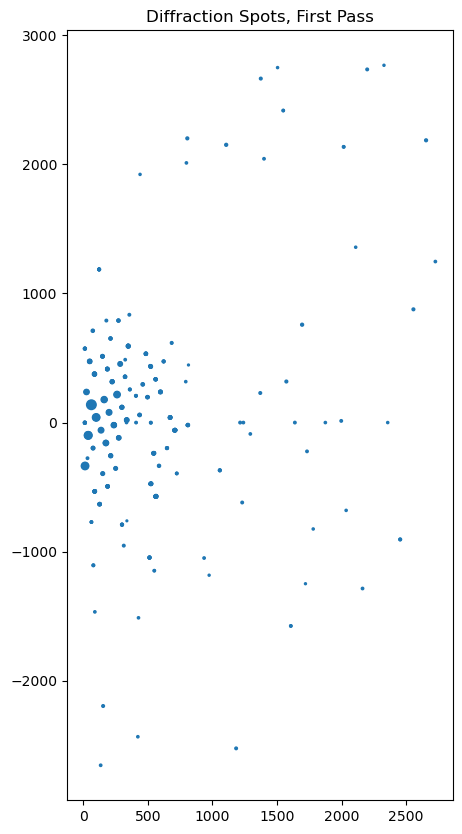

Starting basis: [[138 -99]
 [ 62  37]]
Starting basis size: 34058
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 135.31419624284092
[138  62] is larger than [-99  37]
The updated basis vectors are [39 99][-99  37]
This run resulted in a basis smaller than the last: 22492
The updated basis vectors are: [[ 39 -99]
 [ 99  37]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 91.00883955417763
[39 99] is larger than [-99  37]
The updated basis vectors are [-60 136][-99  37]
This run resulted in a basis larger than the last: 33266
Terminating loop.
------------------------------------


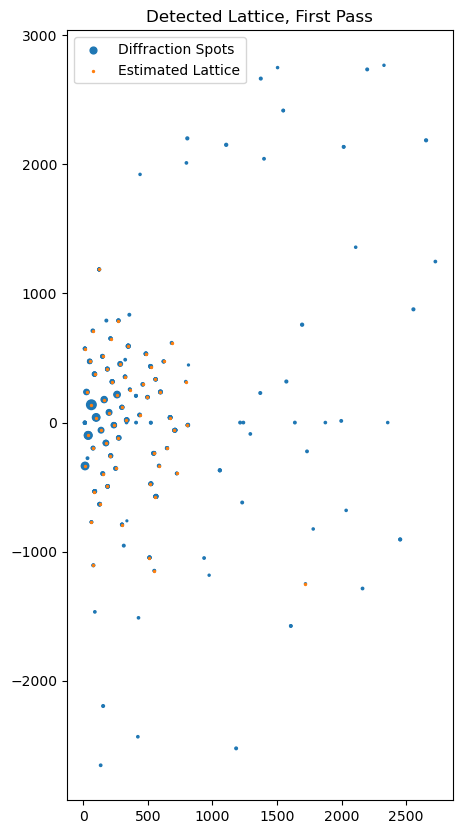

Starting basis: [[ 39 -99]
 [ 99  37]]
Refined_basis: [[ 39.36229594 -98.83331765]
 [ 99.16015353  37.22370443]]
Unit cell dimensions (A): 56.58 57.16
Highest resolution spot (A): 2.84


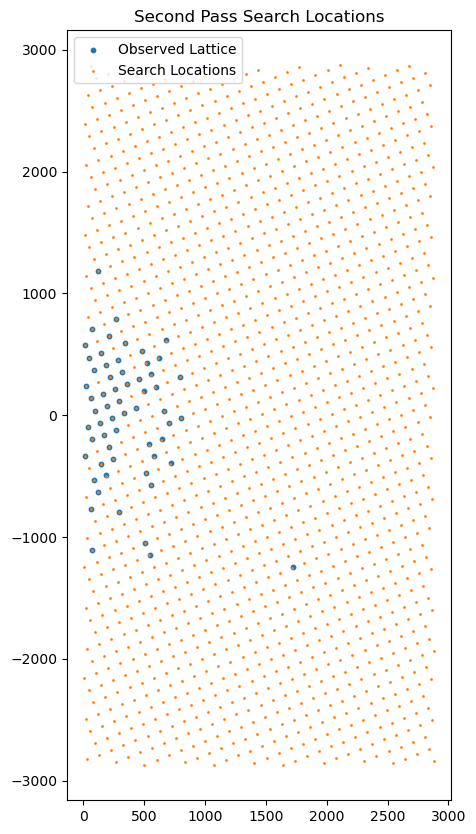

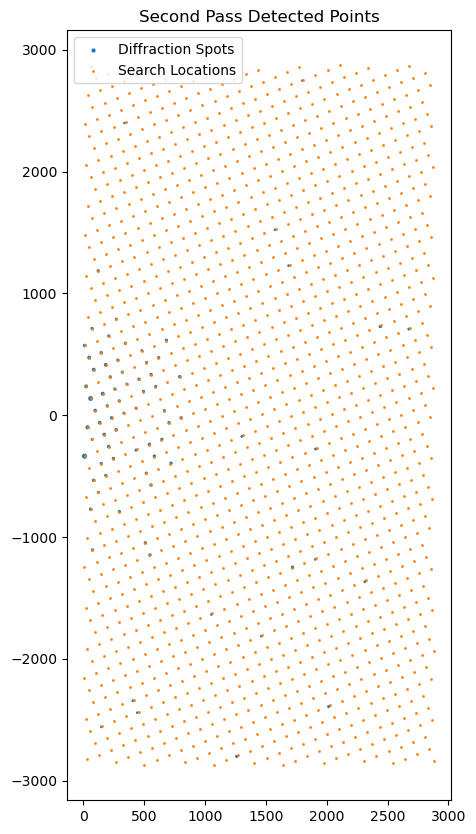

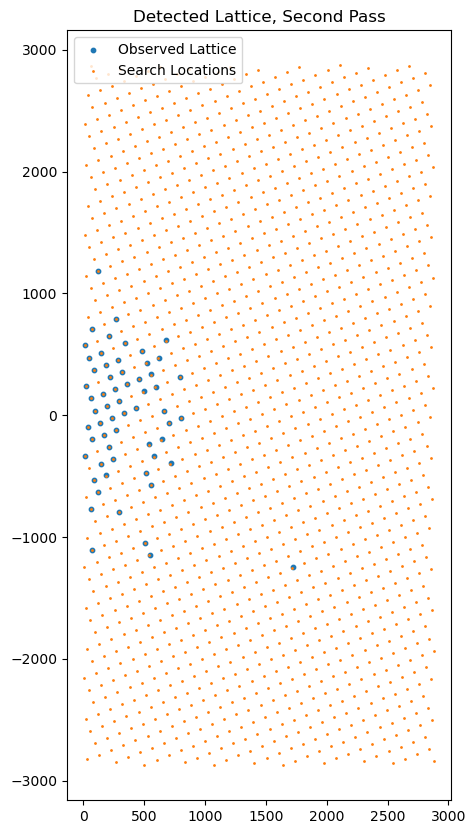

Highest resolution spot from second pass (A): 2.84


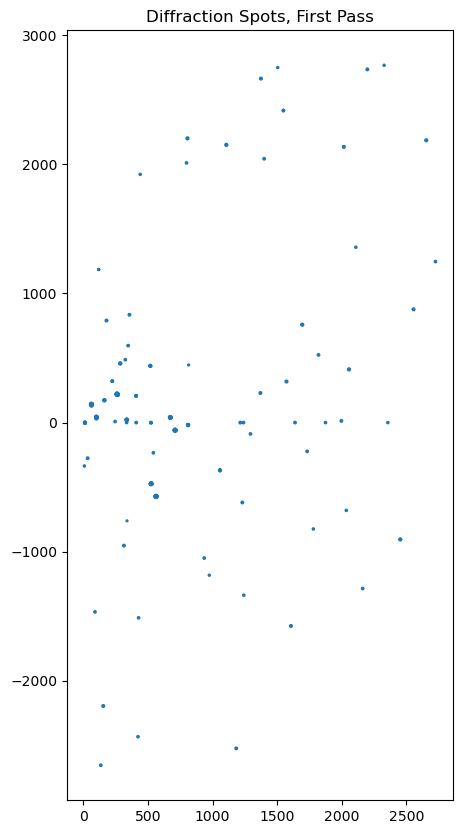

Starting basis: [[220 141]
 [260  61]]
Starting basis size: 139602
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 26.369168933364676
[220 260] is larger than [141  61]
The updated basis vectors are [ 79 199][141  61]
This run resulted in a basis smaller than the last: 69444
The updated basis vectors are: [[ 79 141]
 [199  61]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 44.95319577072957
[ 79 199] is larger than [141  61]
The updated basis vectors are [-62 138][141  61]
This run resulted in a basis smaller than the last: 46490
The updated basis vectors are: [[-62 141]
 [138  61]]
------------------------------------
Running basis shortening...
The angle between the basis vectors is: 90.79873622992724
[141  61] is larger than [-62 138]
The updated basis vectors are [ 79 199][-62 138]
This run resulted in a basis larger than the last: 68730
Terminating loop.
------------

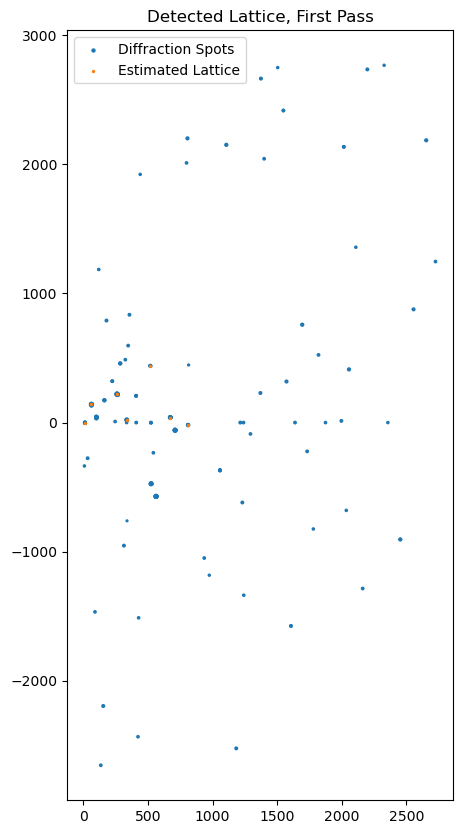

Starting basis: [[-62 141]
 [138  61]]
Refined_basis: [[-60.2        140.13333333]
 [137.7         60.76666667]]
Unit cell dimensions (A): 40.17 39.52
Lattice unit cell min dimension is 39.52 Angstrom. Terminating function.
scipy_ifft(): iFFT performed in 64.99 milliseconds.
Export complete!
test_data/test_lattice.mrc masked successfully!


In [27]:
sax.mask_image(filename,
               filename_out,
               threshold_method = threshold_method,
               pixel_size = pixel_size,
               verbose = verbose,
               show_plots = show_plots,
               threads = threads,
               sigma = sigma,
               num_sd = num_sd,
               num_sd_secondpass = num_sd_secondpass,
               x_window_percent = x_window_percent,
               y_window_percent = y_window_percent,
               miller_index_buffer = miller_index_buffer,
               box_radius = box_radius,
               min_lattice_size = min_lattice_size,
               mask_radius= mask_radius,
               replace_angle = replace_angle,
               epsilon = epsilon,
               return_spots = False,
               return_stats = False,
               return_fft = False,
               return_image = False)